# UNIF

This is Francisco's implemenatation of the UNIF model

In [1]:
# !wget -c https://github.com/ai-center-kth/sentence-cubert/raw/main/model/vocab.txt -P model/

In [2]:
# !pip install transformers
# !pip install tokenizer
# !pip install tensor2tensor

## Pepare the data

The first step to build the model is to prepare the data which is composed of pairs of code snippets and their corresponding natural language descriptions.



### Download the dataset

In [3]:
# !wget -c https://github.com/EdinburghNLP/code-docstring-corpus/raw/master/V2/parallel/parallel_bodies -P ./data/
# !wget -c https://github.com/EdinburghNLP/code-docstring-corpus/raw/master/V2/parallel/parallel_desc -P ./data/

### Explore the data

In [4]:
# DATASET_SIZE = 100000
DATASET_SIZE = 10000

code_snippets_file = './data/parallel_bodies'
with open(code_snippets_file) as f:
    code_snippets = [line.rstrip() for line in f]

descriptions_file = './data/parallel_desc'
# with open(descriptions_file, 'rb') as f:
# with open(descriptions_file, encoding="utf8", errors='ignore') as f:
with open(descriptions_file, encoding="ISO-8859-1") as f:
    descriptions = [line.rstrip() for line in f]

print(code_snippets[0])
print(descriptions[0])

print()
print(code_snippets[10])
print(descriptions[10])

 DCSP fp = open(filename, 'rb') DCNL DCSP source = (fp.read() + '\n') DCNL DCSP try: DCNL DCSP  DCSP co = compile(source, filename, 'exec') DCNL DCSP except SyntaxError: DCNL DCSP  DCSP print >>sys.stderr, '>>Syntax DCSP error DCSP in', filename DCNL DCSP  DCSP raise DCNL DCSP fp.close() DCNL DCSP return co
'load a Python source file and compile it to byte-code DCNL _load_module(filename: string): code_object DCNL filename:   name of file containing Python source code DCNL (normally a .py) DCNL code_object: code_object compiled from this source code DCNL This function does NOT write any file!'

 DCSP for body_charset in ('US-ASCII', 'ISO-8859-1', 'UTF-8'): DCNL DCSP  DCSP try: DCNL DCSP  DCSP  DCSP BODY.encode(body_charset) DCNL DCSP  DCSP except UnicodeError: DCNL DCSP  DCSP  DCSP pass DCNL DCSP  DCSP else: DCNL DCSP  DCSP  DCSP break DCNL DCSP msg = MIMEText(BODY.encode(body_charset), 'html', body_charset) DCNL DCSP msg['From'] = SENDER DCNL DCSP msg['To'] = TO DCNL DCSP msg['Subject

### Tokenize the data

In [5]:
class Tokenizer:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "[CLS]", 1: "[SEP]"}
        self.n_words = 2  # Count CLS and SEP

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def tokenize(self, sentence):
        return [self.word2index[word] for word in sentence.split(' ')]




In [6]:
code_snippet = "DCSP fp = open(filename, 'rb') DCNL DCSP source = (fp.read() + '\n') DCNL DCSP try: DCNL DCSP  DCSP co = compile(source, filename, 'exec') DCNL DCSP except SyntaxError: DCNL DCSP  DCSP print >>sys.stderr, '>>Syntax DCSP error DCSP in', filename DCNL DCSP  DCSP raise DCNL DCSP fp.close() DCNL DCSP return co"
code_tokenizer = Tokenizer()
code_tokenizer.add_sentence(code_snippet)
code_tokens = code_tokenizer.tokenize(code_snippet)

code_snippet_2 = "DCSP fp DCNL DCSP"
code_tokens_2 = code_tokenizer.tokenize(code_snippet_2)

print(code_tokens)
print(code_tokens_2)
print(code_tokenizer.word2count.keys())

[2, 3, 4, 5, 6, 7, 2, 8, 4, 9, 10, 11, 7, 2, 12, 7, 2, 13, 2, 14, 4, 15, 16, 17, 7, 2, 18, 19, 7, 2, 13, 2, 20, 21, 22, 2, 23, 2, 24, 25, 7, 2, 13, 2, 26, 7, 2, 27, 7, 2, 28, 14]
[2, 3, 7, 2]
dict_keys(['DCSP', 'fp', '=', 'open(filename,', "'rb')", 'DCNL', 'source', '(fp.read()', '+', "'\n')", 'try:', '', 'co', 'compile(source,', 'filename,', "'exec')", 'except', 'SyntaxError:', 'print', '>>sys.stderr,', "'>>Syntax", 'error', "in',", 'filename', 'raise', 'fp.close()', 'return'])


In [7]:
MODEL_VOCAB = './model/vocab.txt'
MAX_SEQUENCE_LENGTH = 512






# coding=utf-8
#
# ALL CREDIT GOES TO https://github.com/google-research/google-research/tree/master/cubert
#
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Cross-language tokenization library."""
import enum
import token as python_token
import tokenize
from typing import Iterable
from typing import List
from typing import Mapping
from typing import Optional
from typing import Sequence
from typing import Text
from typing import Tuple


from absl import logging
import dataclasses
import regex  # Using instead of `re` because it handles Unicode classes.
import six


# Quote string for special tokens.
SPECIAL_QUOTE = '___'


def quote_special(content):
  return '{q}{t}{q}'.format(q=SPECIAL_QUOTE, t=content)


# Log level of pedantic messages.
_PEDANTIC = 5

# Punctuation for tokenization.
SENTINEL = '^'
SENTINEL_ESCAPE = 'CARET'


@enum.unique
class TokenKind(enum.Enum):
  """The kind of language-agnostic tokens."""
  NONE = 0  # Sadly, Python2 doesn't support enum.auto()
  PUNCTUATION = 1
  KEYWORD = 2
  IDENTIFIER = 3
  STRING = 4
  COMMENT = 5
  NEWLINE = 6
  EOS = 7
  ERROR = 8
  NUMBER = 9
  WHITESPACE = 10


NEWLINE = quote_special(TokenKind.NEWLINE.name)


@dataclasses.dataclass(frozen=True)
class Position():
  line: int
  column: int


@dataclasses.dataclass(frozen=True)
class TokenMetadata():
  """Metadata about abstract tokens.
  Attributes:
    start: The position of the first character of the token.
    end: The position right after the last character of the token. The line is
      the same as the line of the last character and the column is the
      column immediately following the last column of the token.
  """
  start: Optional[Position] = None
  end: Optional[Position] = None


@dataclasses.dataclass(frozen=True)
class AbstractToken():
  spelling: str
  kind: TokenKind
  metadata: TokenMetadata


@dataclasses.dataclass(frozen=True)
class AbstractMultiToken():
  # We force `spellings` to be a concrete `Tuple`, to simplify equality checks
  # and hashing. Otherwise, `spellings=[1, 2, 3]` and `spellings=(1, 2, 3)`
  # would result in different multi-tokens.
  spellings: Tuple[str]
  kind: TokenKind
  metadata: TokenMetadata


def multi_token_from_token(token):
  return AbstractMultiToken(spellings=(token.spelling,),
                            kind=token.kind,
                            metadata=token.metadata)


# TODO(maniatis): Add a test for this one, and migrate other copies to use
# the same implementation.
def fill_range_with_whitespace(start,
                               end):
  """Yields primitive whitespace/newline tokens to fill a text range.
  We translate multi-line whitespace into single-line whitespace and newlines,
  in a *destructive* canonical fashion. Only space preceding a non-whitespace
  token is preserved. Lines with only whitespace are replaced by a single
  newline token.
  Args:
    start: The beginning of the range.
    end: The end (exclusive) of the range.
  Yields:
    WHITESPACE and NEWLINE abstract tokens.
  Raises:
    ValueError: if `start` does not precede `end`.
  """
  if (start.line, start.column) >= (end.line, end.column):
    raise ValueError('`start` must precede `end`, but we received start %s '
                     'and end %s.' % (start, end))

  current_column = start.column
  current_line = start.line
  while current_line < end.line:
    yield AbstractToken(
        quote_special(TokenKind.NEWLINE.name),
        TokenKind.NEWLINE,
        TokenMetadata(
            # A NEWLINE starts at the colum where it occurs and ends
            # at the first character of the next line.
            start=Position(line=current_line, column=current_column),
            end=Position(line=current_line + 1, column=0)))
    current_column = 0
    current_line += 1

  # At this point, we have consumed all newlines. Add any remaining
  # space until the next, non-whitespace token.
  number_of_final_spaces = end.column - current_column
  if number_of_final_spaces:
    # Note that we canonicalize all column differences as space characters.
    # This, for example, will discard any '\t' characters and replace them
    # with ' '.
    yield AbstractToken(
        ' ' * number_of_final_spaces, TokenKind.WHITESPACE,
        TokenMetadata(
            start=Position(line=current_line, column=current_column),
            end=Position(line=current_line, column=end.column)))


_KINDS_TO_SPLIT_LIKE_WHITESPACE = (TokenKind.COMMENT, TokenKind.STRING,
                                   TokenKind.WHITESPACE)
_KINDS_TO_SPLIT_BY_LENGTH = (TokenKind.COMMENT, TokenKind.STRING,
                             TokenKind.NUMBER, TokenKind.IDENTIFIER,
                             TokenKind.WHITESPACE)

_UPPERCASE = r'\p{Lu}'
_TITLECASE = r'\p{Lt}'

# Here we abuse the term "lowercase", by using it to refer to anything that
# doesn't cause a camel/Pascal case split. For Python, for example, this
# includes Unicode category Nd ("decimal numbers") and Nl ("number letters").
# We assume that before these regular expressions are applied, any
# characters that don't fall into a legal "other" category have been checked.
_LOWERCASE = r'[^\p{Lu}\p{Lt}]'

# In what follows, L, U, and T will be replaced with _LOWERCASE, _UPPERCASE
# and _TITLECASE later.
_CAMEL_AFTER_SNAKE_EXPRESSIONS = [
    # Beginning lowercase.
    r'^{L}+',
    # A single titlecase followed by 0 or more lowercase.
    r'{T}{L}*',
    # Single uppercase followed by multiple lowercase.
    r'{U}{L}+',
    # Multiple uppercase ending right before a titlecase.
    r'{U}+(?={T})',
    # Multiple uppercase ending right before an uppercase followed by lowercase.
    r'{U}+(?={U}{L})',
    # Multiple uppercase to the end.
    r'{U}+$',
]
_CAMEL_AFTER_SNAKE_EXPRESSION = '|'.join(_CAMEL_AFTER_SNAKE_EXPRESSIONS).format(
    L=_LOWERCASE,
    T=_TITLECASE,
    U=_UPPERCASE)
_CAMEL_RE = regex.compile(_CAMEL_AFTER_SNAKE_EXPRESSION, regex.U)  # pytype: disable=module-attr


class StateType(enum.IntEnum):
  INITIAL_STATE = 0
  UPPERCASE_STATE = 1
  LOWERCASE_STATE = 2
  NUMBER_STATE = 3
  SPECIAL_STATE = 4


def code_to_tokens(code):
  """Convert Python source code to list of tokens.
  Removes all trailing whitespace and then tokenizes the text as if it were
  Python source code. Tokens are 5-tuples as used by the built-in tokenize
  module.
  Args:
    code: string containing python source code
  Returns:
    The code represented as a string of packed tokens separated by spaces.
  Raises:
    tokenize.TokenError: When a multi-line token is incomplete. This is
      generated by `tokenize.generate_tokens`.
    IndentationError: When the source code is incorrectly indented. This is
      generated by `tokenize.generate_tokens`.
  """
  token_tuples = list(tokenize.generate_tokens(
      six.StringIO(code.rstrip()).readline))
  logging.vlog(5, 'Code `%s` was tokenized to token tuples `%s`.', code,
               token_tuples)

  # Now we get rid of an extraneous trailing newline token, if it has been
  # produced. This is a difference in the behavior of generate_tokens between
  # Python 2 and Python 3.
  if six.PY3:
    if len(token_tuples) > 1:
      if token_tuples[-2][0] == python_token.NEWLINE:
        del token_tuples[-2]
        logging.vlog(5, 'Tokenization for `%s` was sanitized. Now token tuples '
                     'are `%s`.', code, token_tuples)
    # Another similar failure mode is if the final tokens are DEDENT, there may
    # be an extraneous newline before them.
    if len(token_tuples) > 2:
      current = len(token_tuples) - 2  # Right before ENDMARKER.
      while current and token_tuples[current][0] == tokenize.DEDENT:
        current -= 1
      if current and token_tuples[current][0] == tokenize.NEWLINE:
        del token_tuples[current]
        logging.vlog(5, 'Tokenization for `%s` was sanitized to remove '
                     'trailing newline after DEDENTs. Now token tuples are '
                     '`%s`.', code, token_tuples)

  return token_tuples


def code_to_tokens_simple_lossless(code):
  r"""Convert python source code to list of tokens.
  This is a simple version using spacing and different classes of characters to
  tokenize a string.
  A sentence will be split at "|" in the following patterns:
    upper | upper lower
    upper | number
    upper | special
    lower | upper
    lower | number
    lower | special
    number | upper
    number | lower
    number | special
    special | upper
    special | lower
    special | number
  In addition to splits caused by the type changes above, the code is also split
  at whitespace. However, a sequence of spaces or tabs will not be split unless
  its length is longer than 20.
  For example: "12345  \n\n678" -> ["12345", "  ", "\n", "\n", "678"]
  We do not split sequences of spaces/tabs to avoid long sequences of single
  " " or "\t" tokens caused by deep indentation.
  This tokenizer uses a finite state machine. The definition of the states is in
  the StateType class.
  Args:
    code: String containing Python source code.
  Returns:
    The code represented as a string of tokens separated by spaces.
    For example, "foo  ,1" -> ["foo", "  ", ",", "1"]
  """
  # normal state transitions that will result in splitting
  normal_transitions = [
      (StateType.UPPERCASE_STATE, StateType.NUMBER_STATE),
      (StateType.UPPERCASE_STATE, StateType.SPECIAL_STATE),
      (StateType.LOWERCASE_STATE, StateType.UPPERCASE_STATE),
      (StateType.LOWERCASE_STATE, StateType.NUMBER_STATE),
      (StateType.LOWERCASE_STATE, StateType.SPECIAL_STATE),
      (StateType.NUMBER_STATE, StateType.UPPERCASE_STATE),
      (StateType.NUMBER_STATE, StateType.LOWERCASE_STATE),
      (StateType.NUMBER_STATE, StateType.SPECIAL_STATE),
      (StateType.SPECIAL_STATE, StateType.UPPERCASE_STATE),
      (StateType.SPECIAL_STATE, StateType.LOWERCASE_STATE),
      (StateType.SPECIAL_STATE, StateType.NUMBER_STATE)]
  # output, state
  tokens = []
  state = StateType.INITIAL_STATE
  next_state = None
  memory = []
  for i, inputchar in enumerate(code):
    if inputchar.isupper():
      next_state = StateType.UPPERCASE_STATE
    elif inputchar.islower():
      next_state = StateType.LOWERCASE_STATE
    elif inputchar.isdigit():
      next_state = StateType.NUMBER_STATE
    else:
      next_state = StateType.SPECIAL_STATE

    # splitting cases
    if (state, next_state) in normal_transitions:
      tokens.append(''.join(memory))
      memory = []
    elif (state, next_state) == (StateType.UPPERCASE_STATE,
                                 StateType.LOWERCASE_STATE) and len(memory) > 1:
      tokens.append(''.join(memory[:-1]))
      memory = [memory[-1]]
    elif (state, next_state) == (StateType.SPECIAL_STATE,
                                 StateType.SPECIAL_STATE):
      if inputchar in [' ', '\t'] and inputchar == code[i-1]:
        if len(memory) >= 20:
          tokens.append(''.join(memory))
          memory = []
      elif inputchar.isspace() or code[i-1].isspace():
        tokens.append(''.join(memory))
        memory = []

    # put inputchar into memory, always
    memory.append(inputchar)
    state = next_state
  if memory:
    tokens.append(''.join(memory))
  return tokens


def subtokenize_identifier(identifier):
  """Splits an identifier assuming camel/pascal/snake case conventions.
  This doesn't attempt to classify the identifier as one of snake case/camel/
  pascal, etc. It just applies all possible splits in the order snake case,
  Pascal, camel.
  This doesn't check whether an identifier is a legal identifier for some
  language. It is assumed that the caller has already decided that.
  For Unicode characters in identifiers, we define splitting conventions as
  follows:
  - Snake-case is only defined in terms of the ASCII underscore (U+005F). Other
    characters that may look like an underscore do not introduce a snake-case
    component.
  - For the purpose of Pascal and camel cases, we categorize only the Lu Unicode
    category as uppercase characters, with the exception of the Lt (titlecase)
    character category. Lt characters are treated as a sequence of an uppercase
    character followed by a lowercase character and, as such, may only appear
    in the beginning of a Pascal-case component, but not as an all-uppercase
    component. As an example, if U, L, T are uppercase, lowercase, and titlecase
    characters as defined above (i.e., members of Lu, everything else, or Lt
    categories, respectively), UUUT would be split as UUU and T, ULTL would be
    split as UL and TL, LTL would be split as L and TL, etc.
  Args:
    identifier: A non-empty string, purporting to be an identifier. Assumes its
      validity as an identifier in a given language has already been established
      by the caller.
  Returns:
    A list of substrings of `identifier`. Joining the substrings should return
      the original `identifier` exactly.
  Raises:
    ValueError: if `identifier` is not a legal identifier string.
  """
  snake_splits = identifier.split('_')
  snake_components = []  # type: List[Text]
  current_snake_separator = []  # type: List[Text]
  for snake_split in snake_splits:
    if snake_split:
      snake_components.append(''.join(current_snake_separator))
      current_snake_separator = []
      snake_components.append(snake_split)
    current_snake_separator.append('_')
  # Emit the final separator, but discard the most recent underscore added to
  # it. It should have at least one.
  current_snake_separator.pop()
  if current_snake_separator:
    snake_components.append(''.join(current_snake_separator))

  # Now we want to do camel-case splitting for each non-underscore snake
  # component.
  logging.vlog(_PEDANTIC, 'Split %r into snake case: %r', identifier,
               snake_components)
  all_components = []  # type: List[Text]
  for snake_component in snake_components:
    if '_' in snake_component:
      all_components.append(snake_component)
    else:
      unicodified_snake_component = six.ensure_text(snake_component)
      camel_components = _CAMEL_RE.findall(unicodified_snake_component)
      logging.vlog(_PEDANTIC, 'Split snake component %r into %r components.',
                   unicodified_snake_component, camel_components)
      all_components.extend(camel_components)

  # Finally, we want to combine the underscore components with the component
  # immediately preceding them.
  non_underscore_component = ''
  final_components = []  # type: List[Text]
  for component in all_components:
    if '_' in component:
      # Found an underscore component. Combine it with the previous non-
      # underscore component (if any), emit it, and clear the remembered
      # non-underscore component.
      combined_component = non_underscore_component + component
      final_components.append(combined_component)
      non_underscore_component = ''
    else:
      # This is a non-underscore component.

      if non_underscore_component:
        # We've found two consecutive non-underscore components. Emit the
        # previous one, since it won't be combined with any underscores.
        final_components.append(non_underscore_component)

      # Remember the current non-underscore component, in case we need to
      # combine it with a following underscore.
      non_underscore_component = component
  # We may have collected the final non-underscore component and it wasn't
  # followed by underscores. Just emit it.
  if non_underscore_component:
    final_components.append(non_underscore_component)

  assert (six.ensure_text(
      ''.join(final_components)) == six.ensure_text(identifier)), (
          'Ended up with different identifier when joinining components %r '
          'into combined %r.' % (final_components, identifier))
  return final_components


def sanitize(t, mappings):
  r"""Sanitizes a token to remove "dangerous" characters, like \n and \r."""
  final = t
  for original, sanitized in mappings.items():
    assert len(original) == 1
    final = final.replace(original, sanitized)
  return final


def unsanitize(t, mappings):
  """Unsanitizes a previously sanitized token."""
  final = t
  for original, sanitized in mappings.items():
    assert len(original) == 1
    final = final.replace(sanitized, original)
  return final


def split_long_token(token_string,
                     max_output_token_length):
  """Splits a token losslessly to some maximum length per component.
  A long token is split into multiple tokens. For instance, `'bcd'` with
  `max_output_token_length=2` will become `['bc', 'd']`. No sentinel or other
  split mark is added at this stage.
  A token is assumed to be non-empty.
  Args:
    token_string: The token.
    max_output_token_length: Maximum length of an output token.
  Returns:
    List of split tokens.
  Raises:
    ValueError: if `token` is empty.
  """
  if not token_string:
    raise ValueError('Expected %r to be non-empty' % token_string)

  whole_token_length = len(token_string)
  remainder_length = whole_token_length % max_output_token_length
  even_parts = list(
      map(
          # ...join together...
          ''.join,
          zip(
              # `max_output_token_length` copies of the iterator of
              # whole_token's characters. zip will draw from the same iterator
              # and return `max_output_token_length` tuples of characters from
              # `whole_token`.
              *[iter(token_string)] * max_output_token_length)))
  remainder_part = ([token_string[-remainder_length:]]
                    if remainder_length else [])
  split_token = even_parts + remainder_part
  assert split_token, ('while wrapping >>%s<< into >%r<' %
                       (token_string, split_token))
  assert all([
      len(t) <= max_output_token_length for t in split_token
  ]), ('Got split_token >>>%r<<<, which contains tokens longer than %d.' %
       (split_token, max_output_token_length))
  return split_token


def _agnostic_tokens_to_lists_of_token_lists(
    agnostic_tokens
):
  """Turns each token into a singleton token list, keeping token kinds."""
  return [multi_token_from_token(a) for a in agnostic_tokens]


def _subtokenize_identifiers_heuristically(
    token_lists
):
  """Subtokenizes only identifiers in a list of token lists.
  This assumes that every subtoken list is still a singleton.
  Args:
    token_lists: A list of labelled tokens. Each token is represented as a
      (still) singleton list of subtokens.
  Returns:
    A list of token lists, of which the identifiers are split heuristically.
  """
  with_split_identifiers: List[AbstractMultiToken] = []
  for multi_token in token_lists:
    # spelling_list had better still be a singleton.
    assert len(multi_token.spellings) == 1, (
        'Expected %r to be a singleton, but it is not.' % multi_token)
    if multi_token.kind is TokenKind.IDENTIFIER:
      subtokenized = dataclasses.replace(
          multi_token,
          spellings=subtokenize_identifier(multi_token.spellings[0]))
      with_split_identifiers.append(subtokenized)
    else:
      with_split_identifiers.append(multi_token)
  return with_split_identifiers


def _subtokenize_strings_heuristically(
    token_lists
):
  """Splits STRING, COMMENT, WHITESPACE tokens like text.
  Args:
    token_lists: List of subtoken lists, of which only those of kind IDENTIFIER
      are allowed not to be singletons.
  Returns:
    A list of token lists, of which IDENTIFIER, STRING, NUMBER, COMMENT tokens
      are now split heuristically.
  """
  with_heuristically_split_text: List[AbstractMultiToken] = []
  for multi_token in token_lists:
    if multi_token.kind in _KINDS_TO_SPLIT_LIKE_WHITESPACE:
      assert len(multi_token.spellings) == 1, (
          'Expected %r to be a singleton, but it is not.' % multi_token)
      subtokenized = dataclasses.replace(
          multi_token,
          spellings=code_to_tokens_simple_lossless(multi_token.spellings[0]))
      with_heuristically_split_text.append(subtokenized)
    else:
      with_heuristically_split_text.append(multi_token)
  return with_heuristically_split_text


def _shorten_subtokens(
    token_lists,
    max_output_token_length,
):
  """Further subtokenizes any subtokens that are too long.
  At this point, we're done with all heuristic splitting. Now split what's left
  by length if need be. We don't do anything about keywords or other
  punctuation.
  Args:
    token_lists: List of subtoken lists, of which only those of kinds
      IDENTIFIER, NUMBER, STRING, COMMENT may have been subtokenized.
    max_output_token_length: The max character length for each subtoken of
      the subtokenizable kinds.
  Returns:
    Subtokenized tokens up to a maximum per-subtoken length.
  """
  shortened_subtokens: List[AbstractMultiToken] = []
  for multi_token in token_lists:
    if multi_token.kind in _KINDS_TO_SPLIT_BY_LENGTH:
      shortened_spelling_list: List[str] = []
      for spelling in multi_token.spellings:
        shortened_spelling_list.extend(
            split_long_token(spelling, max_output_token_length))
      shortened_subtokens.append(
          dataclasses.replace(
              multi_token, spellings=tuple(shortened_spelling_list)))
    else:
      shortened_subtokens.append(multi_token)
  return shortened_subtokens


def split_agnostic_tokens(
    agnostic_tokens,
    max_output_token_length,
):
  """Splits each language-agnostic token according to its kind.
  Args:
    agnostic_tokens: The language-agnostic tokens to subtokenize. These are
      pairs of spelling and generic token kind. No subtokenization has been
      done; the tokens are as the language-specific lexer produced them.
    max_output_token_length: The target maximum output token length.
  Returns:
    A list of subtoken lists, with their associated token kind.
  """
  # Prepare for subtokenization.
  agnostic_token_lists = _agnostic_tokens_to_lists_of_token_lists(
      agnostic_tokens)
  # Perform heuristic subtokenizations.
  with_identifiers_heuristically_split = _subtokenize_identifiers_heuristically(
      agnostic_token_lists)
  with_string_tokens_heuristically_split = _subtokenize_strings_heuristically(
      with_identifiers_heuristically_split)
  # Shorten resulting subtokens by length.
  shortened_subtokens = _shorten_subtokens(
      with_string_tokens_heuristically_split, max_output_token_length)

  return shortened_subtokens


def sanitize_subtoken_lists(
    subtoken_lists,
    sanitization_mapping,
    sentinel):
  """Sanitizes lists of subtoken lists, adding sentinels.
  Args:
    subtoken_lists: A list of multi-tokens. Cannot be empty or contain empty
      sublists.
    sanitization_mapping: A mapping from sensitive characters to replacement
      strings. It is assumed to have been checked by `check_mappings`.
    sentinel: The sentinel character. It is expected to be one of the keys
      in `sanitization_mapping`.
  Returns:
    A list of multi-tokens.
  Raises:
    ValueError: If one of the input sublists is empty, or the entire input
      is empty, or the sentinel is not one of the unsanitary characters.
  """
  if not subtoken_lists:
    raise ValueError('Received empty input %r but expected it to be non '
                     'empty' % subtoken_lists)
  if sentinel not in sanitization_mapping:
    raise ValueError('Sentinel %r should be in the sanitization map %r '
                     'but is not.' % (sentinel, sanitization_mapping))

  sanitized_lists = []
  for multi_token in subtoken_lists:
    spellings = multi_token.spellings
    if not spellings:
      raise ValueError('Received empty multi-token %r but expected no empty '
                       'ones' % multi_token)
    sanitized_spellings = [
        sanitize(t, sanitization_mapping)
        for t in spellings
    ]

    # Add the sentinel to all subtokens except the last one.
    with_sentinel = ([t + sentinel for t in sanitized_spellings[:-1]] +
                     [sanitized_spellings[-1]])

    sanitized_lists.append(
        dataclasses.replace(multi_token, spellings=with_sentinel))
  return sanitized_lists


def flatten_subtoken_lists(
    subtoken_lists):
  """Flattens lists of subtoken lists.
  Args:
    subtoken_lists: A list of subtoken lists, one list per initial language
      token. Cannot be empty or contain empty sublits.
  Returns:
    A list of flattened subtokens representing the entire original sequence.
  Raises:
    ValueError: If the input is empty.
  """
  if not subtoken_lists:
    raise ValueError('Received empty input %r but expected it to be non '
                     'empty' % (subtoken_lists,))
  spellings = (t.spellings for t in subtoken_lists)
  subtokens = sum(spellings, [])

  return subtokens


def flatten_and_sanitize_subtoken_lists(
    subtoken_lists,
    sanitization_mapping,
    sentinel):
  """Sanitizes and then flattens lists of subtoken lists, adding sentinels.
  Args:
    subtoken_lists: A list of multi-tokens, one per initial language
      token. Cannot be empty or contain empty sublits.
    sanitization_mapping: A mapping from sensitive characters to replacement
      strings. It is assumed to have been checked by `check_mappings`.
    sentinel: The sentinel character. It is expected to be one of the keys
      in `sanitization_mapping`.
  Returns:
    A list of flattened subtokens representing the entire original sequence.
  Raises:
    ValueError: If one of the input sublists is empty, or the entire input
      is empty, or the sentinel is not one of the unsanitary characters.
  """
  sanitized = sanitize_subtoken_lists(subtoken_lists, sanitization_mapping,
                                      sentinel)
  flattened = flatten_subtoken_lists(sanitized)
  return flattened


def reconstitute_full_unsanitary_tokens(
    split_token_list,
    sanitization_mapping,
    sentinel):
  """Unsplits tokens previously subtokenized and flattened.
  It assumes this is the output of `split_agnostic_tokens`, followed by
  `sanitize_subtoken_lists` and `flatten_subtoken_lists`.
  Split tokens are joined together.  `['bc^', 'd']` will become
  `'bcd'`, where '^' is `SENTINEL` that indicates where joining occurs.
  Args:
    split_token_list: List of split tokens.
    sanitization_mapping: A mapping from sensitive characters to replacement
      strings. It is assumed to have been checked by `check_mappings`.
    sentinel: The sentinel character. It is expected to be one of the keys
      in `sanitization_mapping`.
  Returns:
    Sequence of whole tokens.
  Raises:
    ValueError: if the sentinel character appears in any position other than
      the sentinel position, or if any of the unsanitary characters (as per
      the `sanitization_mapping`) appear anywhere, or if a subtoken is empty,
      or the sentinel is not one of the unsanitary characters.
  """
  if not split_token_list:
    raise ValueError('Received empty input %r but expected it to be non '
                     'empty.' % split_token_list)
  if sentinel not in sanitization_mapping:
    raise ValueError('Sentinel %r should be in the sanitization map %r '
                     'but is not.' % (sentinel, sanitization_mapping))

  whole_token_list = []  # type: List[Text]
  pending_split_tokens = []  # type: List[Text]
  for t in split_token_list:
    if not t:
      raise ValueError('Must have non-empty subtokens, but found %r in %r.' % (
          t, split_token_list))
    if t[-1] == sentinel:
      # Remove sentinel and accumulate until the final one appears.
      pending_split_tokens.append(t[:-1])
    else:
      # It is a final token, so combine everything accumulated into one.
      pending_split_tokens.append(t)
      whole_token = ''.join(pending_split_tokens)
      whole_token_list.append(whole_token)
      pending_split_tokens = []
  # We should have nothing pending.
  if pending_split_tokens:
    raise ValueError('After scanning all subtokens %r, there still is some '
                     'unjoined content: %r' %
                     (split_token_list, pending_split_tokens))

  # At this point we have whole tokens that contain sanitized characters. First
  # we'll see if they are dirty, and then unsanitize them into their original
  # form.
  unsanitary_characters = sanitization_mapping.keys()
  for whole_token in whole_token_list:
    for unsanitary_character in unsanitary_characters:
      if unsanitary_character in whole_token:
        raise ValueError('Reconstructed whole token %r seems to contain a '
                         'character %r that should have been sanitized '
                         'already.' % (whole_token, unsanitary_character))
  # Unsanitize.
  unsanitized_whole_tokens = [
      unsanitize(t, sanitization_mapping) for t in whole_token_list
  ]

  return unsanitized_whole_tokens


def check_mappings(mappings):
  """Checks the correctness of character-to-string sanitization mappings.
  This ensures that all keys are single characters and that no value contains
  any of the keys or other values.
  Args:
    mappings: A mapping from characters to strings.
  Raises:
    ValueError: If a key has length different from 1 or if a key appears in any
      value or if a value is a substring of another value, or if any value is
      empty or non-unique.
  """
  for key in mappings:
    if len(key) != 1:
      raise ValueError('Expecting length-1 strings as keys in mappings, but '
                       'got key %r in mappings %r.' % (key, mappings))

  values = mappings.values()

  if len(values) != len(set(values)):
    raise ValueError('There seem to be some duplicate values in %r, but they '
                     'are expected to be unique.' % mappings)

  if any([not value for value in values]):
    raise ValueError('An empty value found in %r, but no empty values are '
                     'allowed.' % mappings)

  for value in values:
    for other_value in values:
      if value != other_value and value in other_value:
        raise ValueError('Value %r is a substring of %r, but no value may '
                         'be a substring of another.' % (value, other_value))

    for key in mappings:
      if key in value:
        raise ValueError('No key may appear in one of the mapping values, but '
                         'found key %r in value %r, both of which appear in '
                         'the mappings %r.' % (key, value, mappings))


def subtokenize_agnostic_tokens_in_place(
    agnostic_tokens,
    max_output_token_length,
    sanitization_mapping,
    sentinel,
):
  """Subtokenizes language-agnostic tokens, discarding their kind in the end.
  Args:
    agnostic_tokens: The language-agnostic tokens to subtokenize. These are
      pairs of spelling and generic token kind. No subtokenization has been
      done; the tokens are as the language-specific lexer produced them.
    max_output_token_length: The target maximum output token length.
    sanitization_mapping: A mapping from sensitive characters to replacement
      strings. It is assumed to have been checked by `check_mappings`.
    sentinel: The sentinel character. It is expected to be one of the keys
      in `sanitization_mapping`.
  Returns:
    A list of subtoken lists, one per original agnostic token.
  """
  labelled_subtokenized = split_agnostic_tokens(agnostic_tokens,
                                                max_output_token_length)

  subtoken_lists = sanitize_subtoken_lists(labelled_subtokenized,
                                           sanitization_mapping,
                                           sentinel)
  return subtoken_lists







# coding=utf-8
#
# ALL CREDIT GOES TO https://github.com/google-research/google-research/tree/master/cubert
#
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""This module contains utilities for source code tokenization."""

import abc
import tokenize
from typing import Collection
from typing import Dict
from typing import Iterable
from typing import Mapping
from typing import Sequence
from typing import Text
from typing import Union

import dataclasses

# from tokenizer import unified_tokenizer

# After all splitting, the longest a token is of the following length.
MAX_OUTPUT_TOKEN_LENGTH = 15


class CuBertTokenizer(abc.ABC):
    """A tokenizer that implements a language-agnostic tokenization.
    The tokenizer implements a language-agnostic tokenization. This is available
    as `tokenize_and_abstract()`.
    """

    def __init__(self, max_output_token_length=MAX_OUTPUT_TOKEN_LENGTH,
                 reserved=()):
        self.types_to_skip = ()
        self.reserved = reserved
        self.mappings: Dict[str, str]
        self.update_mappings({
            # By default, replace \n and \r. This is meant primarily for literals.
            '\n':
                quote_special('NLCHAR'),
            '\r':
                quote_special('CR'),
            SENTINEL:
                quote_special(
                    SENTINEL_ESCAPE),
        })
        self.max_output_token_length = max_output_token_length

    @abc.abstractmethod
    def tokenize_and_abstract(
            self,
            source_code):
        """Produces a language-agnostic tokenization of the input code.
        Args:
          source_code: Source code stored in a string.
        Returns:
          A list of pairs of a token (string) and a token kind in the given source
            code. It always includes an end of sequence token. That is, an empty
            input always returns a list of size 1.
        Raises:
          ValueError: if `source_code` cannot be tokenized.
        """

    @abc.abstractmethod
    def untokenize_abstract(self, whole_tokens):
        """Applies language-specific rules to an abstract untokenized list.
        Args:
          whole_tokens: Abstract tokens, reconstituted and unsanitized by
            `untokenize` before passed to this language-specific logic.
        Returns:
          A string representing the untokenized text.
        """

    def update_types_to_skip(
        self, types_to_skip
    ):
        """Replaces the set of token types that are ignored.
        Each tokenizer may provide different semantics with respect to this list,
        and may ignore it altogether.
        Args:
          types_to_skip: Types (from the constants in the `token` module) or
            `unified_tokenizer.TokenKind`. Note that some of those constants are
            actually defined in the `tokenize` module.
        """
        self.types_to_skip = types_to_skip

    def replace_reserved_keywords(self, reserved):
        """Replaces the reserved keywords with the supplied list of strings.
        Each tokenizer may provide different semantics with respect to the list
        of reserved keywords, or ignore them altogether.
        Args:
          reserved: List of strings.
        """
        self.reserved = reserved  # Replace the old one entirely.

    def update_mappings(self, mappings):
        """Replaces the character mappings with the supplied dictionary.
        The intent for character mappings is to enable tokenizers that support them
        to sanitize dangerous characters, such as newline and carriage return,
        with a nicer symbol.
        Each tokenizer may provide different semantics with respect to the
        mappings, or ignore them altogether.
        Args:
          mappings: Dictionary of original to sanitized strings. Keys are expected
            to have length 1.
        Raises:
          ValueError: if a key has length different from 1.
        """
        check_mappings(mappings)
        self.mappings = mappings

    def get_mappings(self):
        return self.mappings

    def condition_full_tokens(
        self, agnostic
    ):
        """Applies reserved keywords and character sanitization."""
        filtered: Iterable[AbstractToken] = (
            a for a in agnostic if a.kind not in self.types_to_skip)

        # Now turn all reserved words, regardless of kind, into keywords.
        with_reserved: Sequence[AbstractToken] = tuple(
            dataclasses.replace(a, kind=TokenKind.KEYWORD)
            if a.spelling in self.reserved else a
            for a in filtered)
        return with_reserved

    def subtokenize_full_tokens(
        self, agnostic
    ):
        """Performs heuristic splitting of full tokens."""
        subtoken_lists = subtokenize_agnostic_tokens_in_place(
            agnostic_tokens=agnostic,
            max_output_token_length=self.max_output_token_length,
            sanitization_mapping=self.mappings,
            sentinel=SENTINEL)
        return subtoken_lists

    def tokenize(self, source_code):
        """Tokenizes via `tokenize_and_abstract`."""
        try:
            agnostic = self.tokenize_and_abstract(source_code)
        except Exception as e:
            raise ValueError('While trying to do language-specific tokenization for '
                             'the string:\n\n\n%r\n\n\n%s\n\n\n'
                             'we received error %r.' % (source_code, source_code, e))

        conditioned = self.condition_full_tokens(agnostic)

        multi_tokens = self.subtokenize_full_tokens(conditioned)

        subtokens = flatten_subtoken_lists(multi_tokens)
        return subtokens

    def untokenize(self, token_list):
        """Untokenizes via `untokenize_abstract`."""
        # Untokenize agnostic.
        if (not token_list or token_list[-1] != quote_special(
                TokenKind.EOS.name)):
            raise ValueError('Token list %r should end with the EOS token %r.' %
                             (token_list,
                              quote_special(
                                  TokenKind.EOS.name)))

        whole_tokens = reconstitute_full_unsanitary_tokens(
            token_list,
            sanitization_mapping=self.mappings,
            sentinel=SENTINEL)

        return self.untokenize_abstract(whole_tokens)


def token_from_token_type(token_type):
    """Turns a token type into a reserved token string."""
    # We use the tok_name dict from tokenize, not token. The former has
    # NL and COMMENT and such, whereas the latter doesn't.
    return quote_special(tokenize.tok_name[token_type])





# coding=utf-8
#
# ALL CREDIT GOES TO https://github.com/google-research/google-research/tree/master/cubert
#
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""A Python tokenizer subclass of CuBertTokenizer."""
import keyword
import re
import tokenize
import typing
from typing import Any
from typing import List
from typing import Sequence
from typing import Tuple
from absl import logging
# from . import cubert_tokenizer
# from . import unified_tokenizer


class PythonTokenizer(CuBertTokenizer):
    """Tokenizer that extracts Python's lexical elements preserving strings."""
    _TOKEN_TYPE_MAP = {
        tokenize.COMMENT:    TokenKind.COMMENT,
        tokenize.DEDENT:     TokenKind.KEYWORD,
        tokenize.ENDMARKER:  TokenKind.EOS,
        tokenize.ERRORTOKEN: TokenKind.ERROR,
        tokenize.INDENT:     TokenKind.KEYWORD,
        tokenize.NEWLINE:    TokenKind.NEWLINE,
        tokenize.NL:         TokenKind.PUNCTUATION,
        tokenize.NUMBER:     TokenKind.NUMBER,
        tokenize.OP:         TokenKind.PUNCTUATION,
        tokenize.STRING:     TokenKind.STRING,
    }
    _REVERSE_TOKEN_MAP = {
        token_from_token_type(tokenize.INDENT):
            tokenize.INDENT,
        token_from_token_type(tokenize.DEDENT):
            tokenize.DEDENT,
        quote_special(TokenKind.EOS.name):
            tokenize.ENDMARKER,
        quote_special(TokenKind.ERROR.name):
            tokenize.ERRORTOKEN,
        quote_special(TokenKind.NEWLINE.name):
            tokenize.NEWLINE,
        token_from_token_type(tokenize.NL):
            tokenize.NL,
    }
    # Adding the end-of-string anchor \Z below, since re.fullmatch wasn't
    # available in Python2.
    # pytype: disable=module-attr
    _NUMBERS = re.compile('(' + tokenize.Number + r')\Z')
    # pytype: disable=module-attr
    _SINGLE_STRINGS = re.compile('(' + tokenize.String + r')\Z')
    _TRIPLE_STRING_BEGINNINGS = re.compile(
        tokenize.Triple)  # pytype: disable=module-attr
    # pytype: disable=module-attr
    _COMMENTS = re.compile('(' + tokenize.Comment + r')\Z')

    _EXACT_TOKEN_TYPES = tokenize.EXACT_TOKEN_TYPES.keys()  # pytype: disable=module-attr

    # Token types that CubertTokenizer will tokenize by their type and not
    # content.
    _TOKEN_TYPES_TO_TOKENIZE_BY_TYPE = [
        tokenize.NEWLINE, tokenize.DEDENT, tokenize.NL
    ]

    def tokenize_and_abstract(
            self,
            source_code):
        """Produces a language-agnostic tokenization of the input code."""
        agnostic_tokens: List[AbstractToken] = []

        try:
            token_tuples = code_to_tokens(source_code)
        except (tokenize.TokenError, IndentationError) as e:
            logging.warning('The tokenizer raised exception `%s` while parsing %s', e,
                            source_code)

            # We don't try to do recovery from errors quite yet. Emit just an
            # error and end-of-sequence and return.
            agnostic_tokens.append(
                AbstractToken(
                    quote_special(
                        TokenKind.ERROR.name),
                    TokenKind.ERROR,
                    TokenMetadata(
                        start=Position(
                            line=0, column=0),
                        end=Position(
                            line=0, column=0))))
            agnostic_tokens.append(
                AbstractToken(
                    quote_special(
                        TokenKind.EOS.name),
                    TokenKind.EOS,
                    TokenMetadata(
                        start=Position(
                            line=0, column=0),
                        end=Position(
                            line=0, column=0))))
            return agnostic_tokens

        for token_tuple in token_tuples:
            spelling = token_tuple.string
            kind = token_tuple.type

            # We'll adjust the spelling of some tokens, e.g., those that we
            # tokenize by their type rather than their original spelling. Indentation
            # and dedentation tokens are like that.
            adjusted_spelling = spelling
            token_kind = TokenKind.NONE
            if kind == tokenize.NAME:
                # Disambiguate identifiers from keywords.
                if keyword.iskeyword(spelling):
                    token_kind = TokenKind.KEYWORD
                else:
                    token_kind = TokenKind.IDENTIFIER
            else:
                if kind in PythonTokenizer._TOKEN_TYPES_TO_TOKENIZE_BY_TYPE:
                    # Replace spelling with type.
                    adjusted_spelling = token_from_token_type(
                        kind)
                elif kind is tokenize.INDENT:
                    # For INDENT, in particular, we also record the actual spelling too.
                    adjusted_spelling = '{indent}{spelling}'.format(
                        indent=token_from_token_type(kind),
                        spelling=spelling)
                elif kind == tokenize.ENDMARKER:
                    adjusted_spelling = quote_special(
                        TokenKind.EOS.name)

                # Map everything according to table.
                try:
                    token_kind = PythonTokenizer._TOKEN_TYPE_MAP[kind]
                except KeyError as ke:
                    # It's possible we're here because of async/await. Those kept being
                    # turned into keywords and then removed from keywords, so we can't
                    # rely on knowing which they are. We'll check by spelling.
                    # See: https://bugs.python.org/issue30406
                    # and https://bugs.python.org/issue33260
                    # and https://bugs.python.org/issue35975
                    if spelling in ('async', 'await'):
                        token_kind = TokenKind.KEYWORD
                    else:
                        raise ValueError('While trying to turn Python token %r into an '
                                         'agnostic one, raised %r.' %
                                         ((spelling, kind), ke))

            start_line, start_column = token_tuple.start
            end_line, end_column = token_tuple.end
            # Unlike other languages, NEWLINE tokens are reported as ending on the
            # same line as where they started. We adjust that here, to stick to the
            # same convention as other tokenizers.
            if ((token_kind == TokenKind.NEWLINE) or
                    (kind == tokenize.NL)):
                end_line = start_line + 1
                end_column = 0

            agnostic_tokens.append(
                AbstractToken(
                    spelling=adjusted_spelling, kind=token_kind,
                    metadata=TokenMetadata(
                        # Python's tokenizer counts lines starting from 1, so we
                        # have to offset what we read from the `TokenInfo` tuple.
                        start=Position(
                            line=start_line - 1, column=start_column),
                        end=Position(
                            line=end_line - 1, column=end_column))))

        return agnostic_tokens

    def untokenize_abstract(self, whole_tokens):
        # Reconstruct Python tokenizer tuples, so that Python's untokenize can be
        # invoked.
        token_tuples: List[Tuple[int, str]] = []

        for whole_token in whole_tokens:
            if whole_token in PythonTokenizer._EXACT_TOKEN_TYPES:
                token_tuples.append((tokenize.OP, whole_token))
            elif token_from_token_type(
                    tokenize.INDENT) in whole_token:
                # We baked the type and spelling into one token. Break them up.
                spelling = whole_token.replace(
                    token_from_token_type(tokenize.INDENT), '')
                token_tuples.append((tokenize.INDENT, spelling))
            elif whole_token in PythonTokenizer._REVERSE_TOKEN_MAP:
                python_kind = PythonTokenizer._REVERSE_TOKEN_MAP[whole_token]
                if python_kind in (tokenize.DEDENT, tokenize.ENDMARKER,
                                   tokenize.ERRORTOKEN):
                    spelling = ''
                else:  # python_kind in (tokenize.NEWLINE, tokenize.NL)
                    spelling = '\n'
                token_tuples.append((python_kind, spelling))
            elif keyword.iskeyword(whole_token):
                token_tuples.append((tokenize.NAME, whole_token))
            elif PythonTokenizer._NUMBERS.match(whole_token):
                token_tuples.append((tokenize.NUMBER, whole_token))
            elif PythonTokenizer._SINGLE_STRINGS.match(whole_token):
                token_tuples.append((tokenize.STRING, whole_token))
            elif PythonTokenizer._TRIPLE_STRING_BEGINNINGS.match(whole_token):
                token_tuples.append((tokenize.STRING, whole_token))
            elif PythonTokenizer._COMMENTS.match(whole_token):
                token_tuples.append((tokenize.COMMENT, whole_token))
            else:
                # Everything else we map back to NAME.
                token_tuples.append((tokenize.NAME, whole_token))

        reconstructed = tokenize.untokenize(typing.cast(Any, token_tuples))
        return reconstructed



#
# Thanks to DNGRos for this huggingface/transformers compatible version
# https://github.com/google-research/google-research/issues/582
#
import os
import collections
from typing import *
from transformers import BertTokenizer
# from tensor2tensor.data_generators import text_encoder
from unif import t2t_text_encoder as text_encoder


def combine_tokenizer_with_subword(
    initial_tokenizer: CuBertTokenizer,
    subword_tokenizer: text_encoder.SubwordTextEncoder,
) -> Callable[[str], List[str]]:
    # Try to match the functionality at 
    # https://github.com/google-research/google-research/blob/50c6cd94b5/cubert/code_to_subtokenized_sentences.py#L111-L118
    
    def tokenize(string: str) -> List[str]:
        toks = initial_tokenizer.tokenize(string)
        tokens = flatten_list(
            subword_tokenizer.decode_list(
                subword_tokenizer.encode_without_tokenizing(token)
            )
            for token in toks
        )
        return tokens
    return tokenize


def flatten_list(t):
    return [item for sublist in t for item in sublist]


class CuBertHugTokenizer(BertTokenizer):
    # A hacky version that seems to work at least for python
    def __init__(
        self,
        vocab_file: str,
    ):
        super().__init__(
            vocab_file=vocab_file,
            do_lower_case=False,
            do_basic_tokenize=True,
            unk_token="[UNK]_",
            sep_token="[SEP]_",
            pad_token="<pad>_",
            cls_token="[CLS]_",
            mask_token="[MASK]_",
        )

        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocabulary file at path '{}'. To load the vocabulary from a Google pretrained "
                "model use `tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    vocab_file)
            )
        self.vocab = self.load_vocab(vocab_file)
        self.ids_to_tokens = collections.OrderedDict([(ids, tok) for tok, ids in self.vocab.items()])
        self.first_tokenizer = PythonTokenizer()
        self.subword_tokenizer = text_encoder.SubwordTextEncoder(str(vocab_file))
        self._combined_func = combine_tokenizer_with_subword(
            self.first_tokenizer, self.subword_tokenizer)

    def __call__(self, text):
        return super().__call__(
            text,
            padding='max_length',
            truncation='longest_first',
            max_length=MAX_SEQUENCE_LENGTH
        )

    @property
    def do_lower_case(self):
        return False

    def _tokenize(self, text):
        return self._combined_func(text)

    def convert_tokens_to_string(self, tokens):
        raise NotImplementedError

    def _convert_token_to_id(self, token):
        return self.subword_tokenizer._subtoken_string_to_id[token]

    def load_vocab(self, vocab_file):
        """Loads a vocabulary file into a dictionary."""
        vocab = collections.OrderedDict()
        with open(vocab_file, "r", encoding="utf-8") as reader:
            tokens = reader.readlines()
        for index, token in enumerate(tokens):
            token = token.rstrip("\n")
            vocab[token] = index
        return vocab

In [8]:
!wget -c vocab.txt https://github.com/franpena-kth/learning-deep-learning/raw/master/vocabulary/python_vocabulary.txt

--2021-04-22 08:54:53--  http://vocab.txt/
Resolving vocab.txt (vocab.txt)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘vocab.txt’
--2021-04-22 08:54:53--  https://github.com/franpena-kth/learning-deep-learning/raw/master/vocabulary/python_vocabulary.txt
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/franpena-kth/learning-deep-learning/master/vocabulary/python_vocabulary.txt [following]
--2021-04-22 08:54:54--  https://raw.githubusercontent.com/franpena-kth/learning-deep-learning/master/vocabulary/python_vocabulary.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting respo

In [9]:
MODEL_VOCAB = './python_vocabulary.txt'
code_tokenizer = CuBertHugTokenizer(MODEL_VOCAB)

In [10]:
# tokenizer = CuBertHugTokenizer(MODEL_VOCAB)
import torch

print(code_snippets[0])
print(code_tokenizer(code_snippets[0]))
print(code_tokenizer.tokenize(code_snippets[0]))

# print()
# print(code_snippets[0])
# print(code_tokenizer(code_snippets[0]))
# print(code_tokenizer.tokenize(code_snippets[0]))

print()
print(code_snippets[10])
print(code_tokenizer(code_snippets[10]))
print(code_tokenizer.tokenize(code_snippets[10]))

input_ids = torch.tensor(code_tokenizer(code_snippets[0])['input_ids'], dtype=torch.int)
input_ids = torch.reshape(input_ids, (1, -1))
print('Code token IDs', input_ids.shape)

# tokenized_code = code_tokenizer(code_snippets)
# print(tokenized_code[0])

 DCSP fp = open(filename, 'rb') DCNL DCSP source = (fp.read() + '\n') DCNL DCSP try: DCNL DCSP  DCSP co = compile(source, filename, 'exec') DCNL DCSP except SyntaxError: DCNL DCSP  DCSP print >>sys.stderr, '>>Syntax DCSP error DCSP in', filename DCNL DCSP  DCSP raise DCNL DCSP fp.close() DCNL DCSP return co
{'input_ids': [2, 34, 26, 49988, 26, 1882, 24, 394, 20, 373, 16, 22, 2774, 23, 19, 49989, 26, 49988, 26, 777, 24, 20, 1882, 21, 604, 20, 19, 65, 143, 64, 23, 19, 49989, 26, 49988, 26, 219, 25, 49989, 26, 49988, 26, 49988, 26, 8047, 24, 1337, 20, 777, 16, 373, 16, 22, 4214, 23, 19, 49989, 26, 49988, 26, 217, 4368, 149, 25, 49989, 26, 49988, 26, 49988, 26, 129, 2251, 224, 21, 1237, 16, 26865, 37, 4368, 17, 49988, 37, 17, 463, 17, 49988, 37, 17, 115, 23, 16, 373, 49989, 26, 49988, 26, 49988, 26, 244, 49989, 26, 49988, 26, 1882, 21, 587, 20, 19, 49989, 26, 49988, 26, 60, 8047, 7, 121, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Tokenize natural language

In [11]:
from transformers import BertModel, BertTokenizer, AutoTokenizer
import torch


bert_model = BertModel.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

sentence = 'I love Paris'

tokenization_results = bert_tokenizer(sentence, padding='max_length', add_special_tokens=True, max_length=10, return_tensors='pt')
print('Tokenization results', tokenization_results)

hidden_rep, cls_head = bert_model(tokenization_results['input_ids'], attention_mask=tokenization_results['attention_mask']).values()
print('Token ids', tokenization_results['input_ids'].shape)
print('Hidden rep', hidden_rep.shape)
print('CLS head', cls_head.shape)
# print(hidden_rep)

# https://medium.com/@noa.kel/using-bert-with-pytorch-b9624edcda4e

Tokenization results {'input_ids': tensor([[ 101, 1045, 2293, 3000,  102,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])}
Token ids torch.Size([1, 10])
Hidden rep torch.Size([1, 10, 768])
CLS head torch.Size([1, 768])


## Data Processor

In [12]:
from torch.utils.data import Dataset


class CodeDescDataset(Dataset):

    def __init__(self, code_snippets_file, descriptions_file):
        self.code_tokenizer = CuBertHugTokenizer(MODEL_VOCAB)
        self.desc_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.code_vocab_size = self.code_tokenizer.vocab_size
        self.desc_vocab_size = self.desc_tokenizer.vocab_size
        # Load data here
        # code_snippets_file = './data/parallel_bodies'
        with open(code_snippets_file) as f:
            self.code_snippets = [line.rstrip() for line in f][:DATASET_SIZE]

        # descriptions_file = './data/parallel_desc'
        with open(descriptions_file, encoding="ISO-8859-1") as f:
            self.descriptions = [line.rstrip() for line in f][:DATASET_SIZE]
        
        assert len(self.code_snippets) == len(self.descriptions), 'The code snippets file must have the same size as the descriptions file'
    
    def __len__(self):
        # Return dataset size
        return len(self.code_snippets)
    
    def __getitem__(self, index):
        # Load the code and the descriptions
        code_snippet = self.code_snippets[index]
        description = self.descriptions[index]

        # Return a (code_token_ids, desc_token_ids) tuple
        tokenized_code = self.code_tokenizer(code_snippet)
        tokenized_desc = self.desc_tokenizer(
            description, padding='max_length', add_special_tokens=True,
            max_length=MAX_SEQUENCE_LENGTH, return_tensors='pt',
            truncation=True)
        
        return tokenized_code, tokenized_desc


In [13]:
code_snippets_file = './data/parallel_bodies'
descriptions_file = './data/parallel_desc'

dataset = CodeDescDataset(code_snippets_file, descriptions_file)
code_snippet, description = dataset[0]
print()
code_snippet, description = dataset[10]
print()
code_snippet, description = dataset[100]

# print('Code snippet', code_snippet)
# print('Description', description)

## Model

In [14]:
import torch
from torch import nn
from torch.nn import functional

class OldUNIF(nn.Module):

    def __init__(self, code_vocab_size, desc_vocab_size, embedding_size):
        super(UNIF, self).__init__()
        self.code_embedding_layer = nn.Embedding(num_embeddings=code_vocab_size, embedding_dim=embedding_size)
        self.desc_embedding_layer = nn.Embedding(num_embeddings=desc_vocab_size, embedding_dim=embedding_size)
        attention_weights = torch.nn.init.uniform_(torch.empty(embedding_size, embedding_size, dtype=torch.float32, requires_grad=True))
        self.attention_weights = nn.parameter.Parameter(attention_weights, requires_grad=True)
        # self.cosine_layer = nn.CosineSimilarity()

    def forward(self, code_token_ids, desc_token_ids):

        # print('Max code', torch.max(code_token_ids))
        # print('Max desc', torch.max(desc_token_ids))

        # print('Code embedding layer', self.code_embedding_layer, self.code_embedding_layer.num_embeddings, self.code_embedding_layer.embedding_dim)

        # print('Code tokens IDs', code_token_ids.shape)
        # print('Desc tokens IDs', desc_token_ids.shape)

        code_embedding = self.code_embedding_layer(code_token_ids)
        desc_embedding = self.desc_embedding_layer(desc_token_ids)

        # Calculate the attention weights for the code embedding layer
        # code_embedding = self.attention_weights(code_embedding)
        # print('Attention weights pre', self.attention_weights.shape)
        # print('Code embedding', code_embedding.shape)
        batch_size = code_token_ids.shape[0]
        attention_weights = self.attention_weights.unsqueeze(0).repeat(batch_size, 1, 1)
        # my_tensor.unsqueeze(0).repeat(7, 1, 1)
        # print('Attention weights post', attention_weights.shape)
        # code_embedding = functional.softmax(torch.bmm(attention_weights, code_embedding))
        code_embedding = torch.bmm(code_embedding, attention_weights)
        # code_embedding = torch.bmm(attention_weights, code_embedding)
        code_embedding = torch.sum(code_embedding, 1)
            

        # Calculate the average of the embeddings for the desc embedding layer
        desc_embedding = torch.mean(desc_embedding, 1)

        # output = self.cosine_layer(code_embedding, desc_embedding)

        # print('Code embedding', code_embedding.shape)
        # print('Desc embedding', desc_embedding.shape)

        return code_embedding, desc_embedding
    
    def encode_code_snippet(self, code_token_ids):
        code_embedding = self.code_embedding_layer(code_token_ids)
        batch_size = 1
        attention_weights = self.attention_weights.unsqueeze(0).repeat(batch_size, 1, 1)
        code_embedding = torch.bmm(code_embedding, attention_weights)

        return code_embeddings
    
    def encode_description(self, code_desc_ids):

        desc_embedding = self.desc_embedding_layer(desc_token_ids)
        return desc_embedding



In [15]:
class UNIF(nn.Module):

    def __init__(self, code_vocab_size, desc_vocab_size, embedding_size):
        super(UNIF, self).__init__()
        self.code_embedding_layer = nn.Embedding(num_embeddings=code_vocab_size, embedding_dim=embedding_size)
        self.desc_embedding_layer = nn.Embedding(num_embeddings=desc_vocab_size, embedding_dim=embedding_size)
        attention_weights = torch.nn.init.uniform_(torch.empty(embedding_size, 1, dtype=torch.float32, requires_grad=True))
        self.attention_weights = nn.parameter.Parameter(attention_weights, requires_grad=True)
        # self.cosine_layer = nn.CosineSimilarity()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, code_token_ids, desc_token_ids):

        # print('Max code', torch.max(code_token_ids))
        # print('Max desc', torch.max(desc_token_ids))

        # print('Code embedding layer', self.code_embedding_layer, self.code_embedding_layer.num_embeddings, self.code_embedding_layer.embedding_dim)

        # print('Code tokens IDs', code_token_ids.shape)
        # print('Desc tokens IDs', desc_token_ids.shape)

        code_embedding = self.code_embedding_layer(code_token_ids)
        desc_embedding = self.desc_embedding_layer(desc_token_ids)

        # Calculate the attention weights for the code embedding layer
        # code_embedding = self.attention_weights(code_embedding)
        # print('Attention weights pre', self.attention_weights.shape)
        # print('Code embedding', code_embedding.shape)
        batch_size = code_token_ids.shape[0]
        attention_weights = self.attention_weights.unsqueeze(0).repeat(batch_size, 1, 1)
        # attention_weights = self.attention_weights.unsqueeze(0).repeat(batch_size, 1).unsqueeze(-1)
        # print('Attention weights post', attention_weights.shape)
        # code_embedding = functional.softmax(torch.bmm(attention_weights, code_embedding))
        # code_embedding = torch.bmm(code_embedding, attention_weights)
        # attention_scores = torch.where(mask.view(batch_size, -1) != 0., torch.bmm(context, query).squeeze(-1), self.minus_inf)
        attention_scores = torch.bmm(code_embedding, attention_weights).squeeze(-1)
        # print('Attention scores', attention_scores.shape)
        # code_embedding = torch.bmm(attention_weights, code_embedding)
        attention_weights = self.softmax(attention_scores.squeeze(-1))
        # print('Attention weights softmax', attention_weights.shape)
        
        # code_embedding = torch.sum(code_embedding, 1)
        code_embedding = (attention_weights.unsqueeze(-1) * code_embedding).sum(1)
        # print('Code embedding sum', code_embedding.shape)

            

        # Calculate the average of the embeddings for the desc embedding layer
        desc_embedding = torch.mean(desc_embedding, 1)

        # output = self.cosine_layer(code_embedding, desc_embedding)

        # print('Code embedding', code_embedding.shape)
        # print('Desc embedding', desc_embedding.shape)

        return code_embedding, desc_embedding
    
    def encode_code_snippet(self, code_token_ids):
        code_embedding = self.code_embedding_layer(code_token_ids)
        batch_size = 1
        attention_weights = self.attention_weights.unsqueeze(0).repeat(batch_size, 1, 1)
        code_embedding = torch.bmm(code_embedding, attention_weights)

        return code_embeddings
    
    def encode_description(self, code_desc_ids):

        desc_embedding = self.desc_embedding_layer(desc_token_ids)
        return desc_embedding

## Training the model

In [16]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def train(model, loss_function, optimiser, code_token_ids, desc_token_ids):
    model.zero_grad()

    code_embedding, desc_embedding = model(code_token_ids, desc_token_ids)

    POSITIVE_SIMILARITY = torch.ones(1)
    NEGATIVE_SIMILARITY = -torch.ones(1)
    loss = loss_function(code_embedding, desc_embedding, POSITIVE_SIMILARITY)
    loss.backward()
    optimiser.step()

    return code_embedding, desc_embedding, loss.item()


def train_cycle():
    # n_iters = 100000
    # print_every = 5000
    # plot_every = 1000
    n_iters = DATASET_SIZE
    print_every = 500
    plot_every = 500
    embedding_size = 128

    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()
    code_snippets_file = './data/parallel_bodies'
    descriptions_file = './data/parallel_desc'
    dataset = CodeDescDataset(code_snippets_file, descriptions_file)
    n_hidden = 128
    model = UNIF(dataset.code_vocab_size, dataset.desc_vocab_size, embedding_size)

    loss_function = nn.CosineEmbeddingLoss()
    learning_rate = 0.005  # If you set this too high, it might explode. If too low, it might not learn
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for iter in range(n_iters):
        # print(iter)
        tokenized_code, tokenized_desc = dataset[iter]
        code_token_ids = torch.tensor(tokenized_code['input_ids'], dtype=torch.int)
        code_token_ids = code_token_ids.reshape(1, -1)
        desc_token_ids = tokenized_desc['input_ids']
        desc_token_ids = desc_token_ids.reshape(1, -1)
        code_embedding, desc_embedding, loss = train(model, loss_function, optimiser, code_token_ids, desc_token_ids)
        current_loss += loss

        # Print iter number, loss, name and guess
        if (iter + 1) % print_every == 0:
            print('%d %d%% (%s) %.4f' % (iter + 1, (iter + 1) / n_iters * 100, timeSince(start), current_loss / print_every))

        # Add current loss avg to list of losses
        if (iter + 1) % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    return model, current_loss, all_losses

## Plot the results

In [17]:
import matplotlib.pyplot as plt


def plot(all_losses):
    plt.figure()
    plt.plot(all_losses)
    plt.show()

500 5% (0m 11s) 0.9036
1000 10% (0m 19s) 0.8806
1500 15% (0m 27s) 0.8351
2000 20% (0m 36s) 0.8060
2500 25% (0m 44s) 0.7886
3000 30% (0m 53s) 0.7804
3500 35% (1m 2s) 0.7345
4000 40% (2m 36s) 0.7112
4500 45% (2m 43s) 0.6677
5000 50% (2m 51s) 0.6370
5500 55% (2m 59s) 0.6180
6000 60% (3m 6s) 0.5979
6500 65% (3m 14s) 0.5642
7000 70% (3m 21s) 0.5434
7500 75% (3m 29s) 0.5259
8000 80% (3m 37s) 0.5050
8500 85% (3m 45s) 0.5252
9000 90% (3m 54s) 0.5898
9500 95% (4m 1s) 0.4439
10000 100% (4m 9s) 0.4047


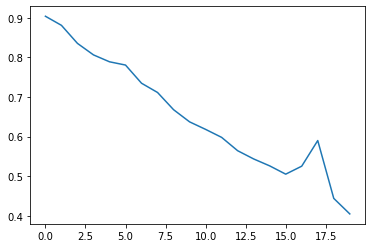

In [18]:
import random
import numpy

torch.manual_seed(0)
random.seed(0)
numpy.random.seed(0)

unif_model, current_loss, all_losses = train_cycle()
plot(all_losses)

In [19]:
# plot(all_losses)
# attention_weights = self.attention_weights.repeat(batch_size, 1, 1)

my_tensor = torch.tensor(range(10)).reshape(2,5)
print(my_tensor.shape)
B = my_tensor.unsqueeze(0).repeat(7, 1, 1)
print(B.shape)

torch.Size([2, 5])
torch.Size([7, 2, 5])


In [20]:
# torch.save(model.state_dict(), f'./unif_model_attention.ckpt')

## Evaluation

In [21]:
# def evaluate(model, dataX, dataY, scaler, train_size, sequence_length):
#     model.eval()
#     with torch.no_grad():
#         loss_function = nn.MSELoss()
#         model.reset_hidden_state(dataX.size(0))
#         predicted_test = model(dataX)
#         loss = loss_function(predicted_test, dataY)
#         print(f'Test set loss: {loss.item():10.10f}')
#         plot_series(
#             sequence_length, dataX[0, :, 0], dataY[0, 0], predicted_test[0, 0])

#         plot_true_vs_predicted(dataY, predicted_test, train_size, scaler)


def evaluate(model, loss_function, code_token_ids, desc_token_ids):
    model.eval()

    with torch.no_grad():
        code_embedding, desc_embedding = model(code_token_ids, desc_token_ids)
        POSITIVE_SIMILARITY = torch.ones(1)
        NEGATIVE_SIMILARITY = -torch.ones(1)
        loss = loss_function(code_embedding, desc_embedding, POSITIVE_SIMILARITY)
        # print(f'Test set loss: {loss.item():10.10f}')

    return code_embedding, desc_embedding, loss.item()


def evaluation_cycle(model):
    # n_iters = 100000
    # print_every = 5000
    # plot_every = 1000
    n_iters = DATASET_SIZE
    print_every = 500
    plot_every = 500
    embedding_size = 128

    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()
    code_snippets_file = './data/parallel_bodies'
    descriptions_file = './data/parallel_desc'
    dataset = CodeDescDataset(code_snippets_file, descriptions_file)
    n_hidden = 128
    model = UNIF(dataset.code_vocab_size, dataset.desc_vocab_size, embedding_size)

    loss_function = nn.CosineEmbeddingLoss()

    tokenized_code_data = torch.empty(len(dataset), MAX_SEQUENCE_LENGTH, dtype=torch.int)
    tokenized_desc_data = torch.empty(len(dataset), MAX_SEQUENCE_LENGTH, dtype=torch.int)

    for iter in range(n_iters):
        # print(iter)
        tokenized_code, tokenized_desc = dataset[iter]
        code_token_ids = torch.tensor(tokenized_code['input_ids'], dtype=torch.int)
        code_token_ids = code_token_ids.reshape(1, -1)
        desc_token_ids = tokenized_desc['input_ids']
        desc_token_ids = desc_token_ids.reshape(1, -1)
        tokenized_code_data[iter] = code_token_ids
        tokenized_desc_data[iter] = desc_token_ids
    
    print(tokenized_code_data.shape)
    print(tokenized_desc_data.shape)
    # print(tokenized_code_data[0])
    # print(tokenized_code_data[10])
    # print(tokenized_desc_data[0])
    # print(tokenized_desc_data[10])

    # for iter in range(n_iters):
    #     # print(iter)
    #     tokenized_code, tokenized_desc = dataset[iter]
    #     code_token_ids = torch.tensor(tokenized_code['input_ids'], dtype=torch.int)
    #     code_token_ids = code_token_ids.reshape(1, -1)
    #     desc_token_ids = tokenized_desc['input_ids']
    #     desc_token_ids = desc_token_ids.reshape(1, -1)
    #     code_embedding, desc_embedding, loss = evaluate(model, loss_function, code_token_ids, desc_token_ids)
    #     # print('Code embedding', code_embedding.shape)
    #     # print('Desc embedding', desc_embedding.shape)
    #     current_loss += loss

    #     # Print iter number, loss, name and guess
    #     if (iter + 1) % print_every == 0:
    #         print('%d %d%% (%s) %.4f' % (iter + 1, (iter + 1) / n_iters * 100, timeSince(start), current_loss / print_every))

    #     # Add current loss avg to list of losses
    #     if (iter + 1) % plot_every == 0:
    #         all_losses.append(current_loss / plot_every)
    #         current_loss = 0

    return model, current_loss, all_losses

In [22]:
def tokenize_data(dataset):

    start = time.time()

    tokenized_code_data = torch.empty(len(dataset), MAX_SEQUENCE_LENGTH, dtype=torch.int)
    tokenized_desc_data = torch.empty(len(dataset), MAX_SEQUENCE_LENGTH, dtype=torch.int)

    for iter in range(len(dataset)):
        # print(iter)
        tokenized_code, tokenized_desc = dataset[iter]
        code_token_ids = torch.tensor(tokenized_code['input_ids'], dtype=torch.int)
        code_token_ids = code_token_ids.reshape(1, -1)
        desc_token_ids = tokenized_desc['input_ids']
        desc_token_ids = desc_token_ids.reshape(1, -1)
        tokenized_code_data[iter] = code_token_ids
        tokenized_desc_data[iter] = desc_token_ids
    
    # print(tokenized_code_data.shape)
    # print(tokenized_desc_data.shape)

    finish = time.time()
    total_time = finish - start

    print('Time: ', total_time)

    return tokenized_code_data, tokenized_desc_data

In [23]:
code_snippets_file = './data/parallel_bodies'
descriptions_file = './data/parallel_desc'
dataset = CodeDescDataset(code_snippets_file, descriptions_file)

tokenized_code_data, tokenized_desc_data = tokenize_data(dataset)
print('Tokenized code data', tokenized_code_data.shape)
print('Tokenized desc data', tokenized_desc_data.shape)

Time:  119.98514676094055
Tokenized code data torch.Size([10000, 512])
Tokenized desc data torch.Size([10000, 512])


In [24]:
code_embedding_data, desc_embedding_data = unif_model(tokenized_code_data, tokenized_desc_data)
print('Code embedding data', code_embedding_data.shape)
print('Desc embedding data', desc_embedding_data.shape)

Code embedding data torch.Size([10000, 128])
Desc embedding data torch.Size([10000, 128])


In [25]:
torch.manual_seed(0)
random.seed(0)
numpy.random.seed(0)

# evaluation_cycle(model)
# model, current_loss, all_losses = evaluation_cycle()
# plot(all_losses)

In [26]:
import torch
from torch import nn
import numpy


def get_top_n(n, results):
    count = 0
    for r in results:
        if results[r] < n:
            count+= 1
    return count / len(results)


def my_test(code_embeddings, desc_embeddings):

    with torch.no_grad():
        cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
        results = {}

        for rowid, desc_embedding in enumerate(desc_embeddings):
            # Calculate the cosine similarity between the code and desc embeddings
            code_desc_similarity = cosine_similarity(code_embeddings[rowid].reshape((1, -1)), desc_embedding.reshape((1, -1)))

            other_code_embeddings = numpy.delete(code_embeddings, rowid, 0)
            tiled_desc = torch.Tensor(numpy.tile(desc_embedding, (other_code_embeddings.shape[0], 1)))

            # print('Other + tiled', other_code_embeddings.shape, tiled_desc.shape)

            # Calculate the cosine similarity between the description vector and all the code snippets excepting the code that matches the desc
            ress = cosine_similarity(other_code_embeddings, tiled_desc)
            results[rowid] = len(ress[ress > code_desc_similarity])
        
        top_1 = get_top_n(1, results)
        top_3 = get_top_n(3, results)
        top_5 = get_top_n(5, results)

        print('Top 1', top_1)
        print('Top 3', top_3)
        print('Top 5', top_5)


code_embeddings = [
    [1.0, 3.0],
    [1.1, 3.0],
    [2.0, -1.0],
]

desc_embeddings = [
    [1.1, 3.0],
    [4.0, 5.0],
    [1.0, 3.0],
]

code_embeddings = torch.Tensor(code_embeddings)
desc_embeddings = torch.Tensor(desc_embeddings)

print(code_embeddings.shape)
print(desc_embeddings.shape)

my_test(code_embeddings, desc_embeddings)

input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)
output = cos(code_embeddings, desc_embeddings)

print(input1.shape, input2.shape, output.shape)


torch.Size([3, 2])
torch.Size([3, 2])
Top 1 0.3333333333333333
Top 3 1.0
Top 5 1.0
torch.Size([100, 128]) torch.Size([100, 128]) torch.Size([3])


In [27]:
# def get_top_n(n, results):
#     count = 0
#     for r in results:
#         if results[r] < n:
#             count+= 1
#     return count / len(results)


# # def test(code_embeddings, desc_embeddings):
# def test(data_path, cos_model, results_path, code_length, desc_length, batch_id):
#     test_tokens = load_hdf5(data_path + "test.tokens.h5" , 0, 10000)
#     test_desc = load_hdf5(data_path + "test.desc.h5" , 0, 10000)

#     test_tokens = pad(test_tokens, code_length)
#     test_desc = pad(test_desc, desc_length)

#     results = {}
#     progress_bar = tqdm(total=len(test_desc))

#     for rowid, desc in enumerate(test_desc):

#         # Calculate the cosine similarity between the code and desc embeddings
#         expected_best_result = cos_model.predict([test_tokens[rowid].reshape((1, -1)), test_desc[rowid].reshape((1, -1))])[0][0]
#         deleted_tokens = np.delete(test_tokens, rowid, 0)
#         tiled_desc = np.tile(desc, (deleted_tokens.shape[0], 1))

#         # Calculate the cosine similarity between the description vector and all the code snippets excepting the code that matches the desc
#         ress = cos_model.predict([deleted_tokens, tiled_desc], batch_size=32*4)
#         results[rowid] = len(ress[ress > expected_best_result])
#         progress_bar.update(1)

#     progress_bar.close()

#     top_1 = get_top_n(1, results)
#     top_3 = get_top_n(3, results)
#     top_5 = get_top_n(5, results)

#     print(top_1)
#     print(top_3)
#     print(top_5)

#     name = results_path+"/results-unif-dcs-" + time.strftime("%Y%m%d-%H%M%S") + ".csv"

#     f = open(name, "a")

#     f.write("batch,top1,top3,top5\n")
#     f.write(str(batch_id)+","+str(top_1) + "," + str(top_3) + "," + str(top_5) + "\n")
#     f.close()




In [28]:
my_test(code_embedding_data, desc_embedding_data)

Top 1 0.0001
Top 3 0.0003
Top 5 0.0004
